# GCN

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = "drive/MyDrive/ECE232E/PS2/cora"
!pip install torch-geometric

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 11.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=626d5a5b956c97252c4918d3b6e0f4eae77132e0bbb7689662b05e05f374e4bb
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [2]:
import numpy as np
import os
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from scipy.sparse import coo_matrix
from torch_geometric.nn import GCNConv
from sklearn.utils import shuffle
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [3]:
all_data = []
all_edges = []

for root,dirs,files in os.walk(path):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())          

all_data = shuffle(all_data,random_state=42)

In [17]:
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] 
Feature = X.shape[1]
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', Feature)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Case_Based', 'Probabilistic_Methods', 'Neural_Networks', 'Theory', 'Rule_Learning', 'Genetic_Algorithms', 'Reinforcement_Learning'}

Number of classes:  7


In [22]:
edge_list2 = []
for edge in edge_list:
    a = edge[0]
    b = edge[1]
    edge_list2.append((b, a))

edge_list3 = edge_list + edge_list2
repeat_items = [key for key,value in Counter(edge_list3).items()if value > 1]
print(repeat_items[:5])
print(len(repeat_items))

[('35', '210871'), ('130', '39403'), ('506', '89416'), ('910', '5462'), ('910', '5869')]
302


In [20]:
('35', '210871') in edge_list

True

In [21]:
('210871', '35') in edge_list

True

In [24]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)
A = nx.adjacency_matrix(G)
A

<2708x2708 sparse array of type '<class 'numpy.int64'>'
	with 10556 stored elements in Compressed Sparse Row format>

In [26]:
# get 20 train instances per class
# remaining instances are in test set test  
labels
train_index = []
counter = {}
for i, label in enumerate(labels):
    if label not in counter:
        counter[label] = 1
    else:
        counter[label] += 1
    if counter[label] <= 20:
        train_index.append(i)

train_index = np.array(train_index)
train_mask = np.zeros(N, dtype=bool)
train_mask[train_index] = True
test_mask = np.logical_not(train_mask)

class_dict = {'Neural_Networks': 0, 'Genetic_Algorithms': 1, 'Theory': 2, 
              'Case_Based': 3, 'Probabilistic_Methods': 4, 'Rule_Learning': 5, 
              'Reinforcement_Learning': 6} 

Y = [class_dict[s] for s in labels]

labels_train = [labels[i] for i in train_index]
labels_test = [labels[i] for i in range(len(X)) if i not in train_index]
print('train label summary', Counter(labels_train))
print('test label summary', Counter(labels_test))

train label summary Counter({'Neural_Networks': 20, 'Genetic_Algorithms': 20, 'Theory': 20, 'Case_Based': 20, 'Probabilistic_Methods': 20, 'Rule_Learning': 20, 'Reinforcement_Learning': 20})
test label summary Counter({'Neural_Networks': 798, 'Probabilistic_Methods': 406, 'Genetic_Algorithms': 398, 'Theory': 331, 'Case_Based': 278, 'Reinforcement_Learning': 197, 'Rule_Learning': 160})


Epoch: 10, Loss: 0.35564014315605164
Epoch: 20, Loss: 0.035022445023059845
Epoch: 30, Loss: 0.009495888836681843
Epoch: 40, Loss: 0.007644671015441418
Epoch: 50, Loss: 0.010117771103978157
Epoch: 60, Loss: 0.01371563971042633
Epoch: 70, Loss: 0.01548402477055788
Epoch: 80, Loss: 0.015066196210682392
Epoch: 90, Loss: 0.013935328461229801
Epoch: 100, Loss: 0.013002212159335613


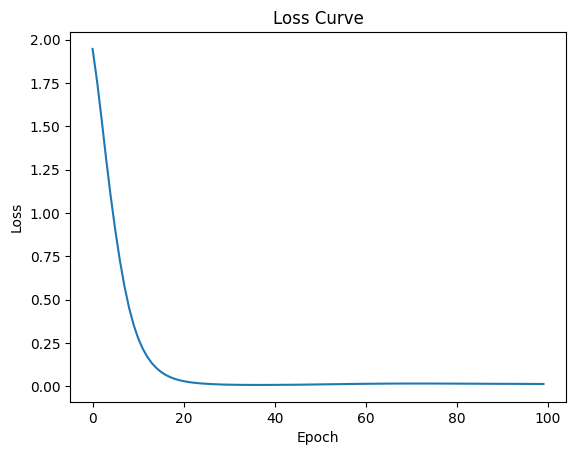

Accuracy: 0.8104


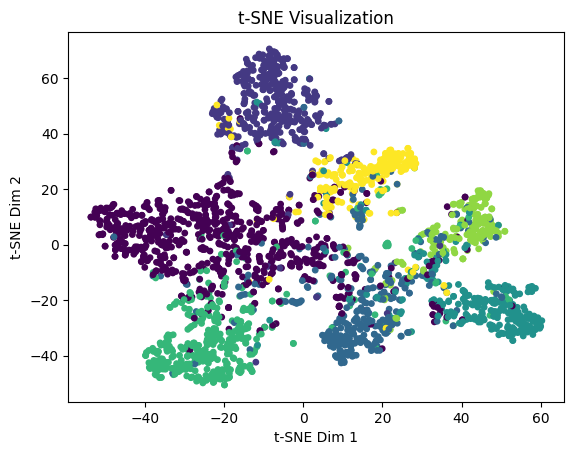

In [ ]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

def sparse_to_edge_index(sparse_mx):
    sparse_mx = sparse_mx.tocoo()
    row, col = sparse_mx.row, sparse_mx.col
    edge_index = np.stack((row, col), axis=0)
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = sparse_to_edge_index(A)  

model = GCN(input_dim=Feature, hidden_dim=32, output_dim=7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()


X = torch.tensor(X, dtype=torch.float)
train_mask = torch.tensor(train_mask, dtype=torch.bool)
test_mask = torch.tensor(test_mask, dtype=torch.bool)
Y = torch.tensor(Y, dtype=torch.long)

loss_history = []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X, edge_index)

    loss = criterion(output[train_mask], Y[train_mask])
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

model.eval()
output = model(X, edge_index)
_, pred = output.max(dim=1)

correct = float(pred[test_mask].eq(Y[test_mask]).sum().item())
accuracy = correct / test_mask.sum().item()
print("Accuracy: {:.4f}".format(accuracy))

model.eval()
output = model(X, edge_index).detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
output_2d = tsne.fit_transform(output)

plt.scatter(output_2d[:, 0], output_2d[:, 1], c=Y.numpy(), cmap='viridis', s=15)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE Visualization")
plt.show()

# Node2Vec

In [ ]:
!pip install node2vec
from node2vec import Node2Vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
node2vec = Node2Vec(G, dimensions=32, walk_length=30, num_walks=100, workers=4)
model = node2vec.fit(window=5, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

In [ ]:
node_embeddings = np.zeros((len(G.nodes), 32))
for i, node_id in enumerate(nodes):
    node_embeddings[i] = model.wv[str(node_id)]
N2V = torch.tensor(node_embeddings, dtype=torch.float)


structure_only
Epoch: 10, Loss: 1.2938777208328247
Epoch: 20, Loss: 0.5229620337486267
Epoch: 30, Loss: 0.24367141723632812
Epoch: 40, Loss: 0.12176982313394547
Epoch: 50, Loss: 0.06853846460580826
Epoch: 60, Loss: 0.043918922543525696
Epoch: 70, Loss: 0.030741065740585327
Epoch: 80, Loss: 0.023268021643161774
Epoch: 90, Loss: 0.01858089305460453
Epoch: 100, Loss: 0.015491771511733532


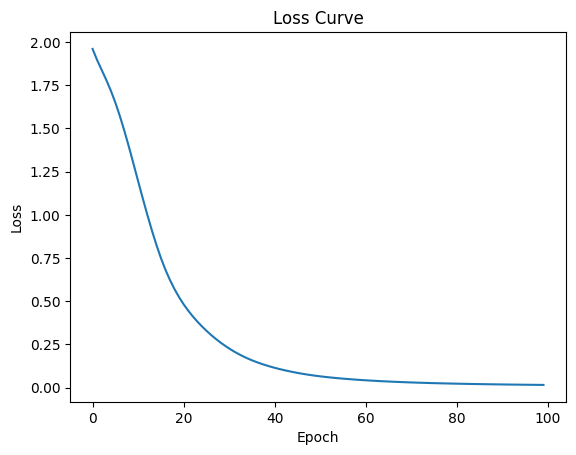

Accuracy: 0.6819

text_only
Epoch: 10, Loss: 0.3785625100135803
Epoch: 20, Loss: 0.034612782299518585
Epoch: 30, Loss: 0.006903890985995531
Epoch: 40, Loss: 0.0031218400690704584
Epoch: 50, Loss: 0.002907062415033579
Epoch: 60, Loss: 0.004034098237752914
Epoch: 70, Loss: 0.005656548775732517
Epoch: 80, Loss: 0.006790462415665388
Epoch: 90, Loss: 0.007245695684105158
Epoch: 100, Loss: 0.007239445578306913


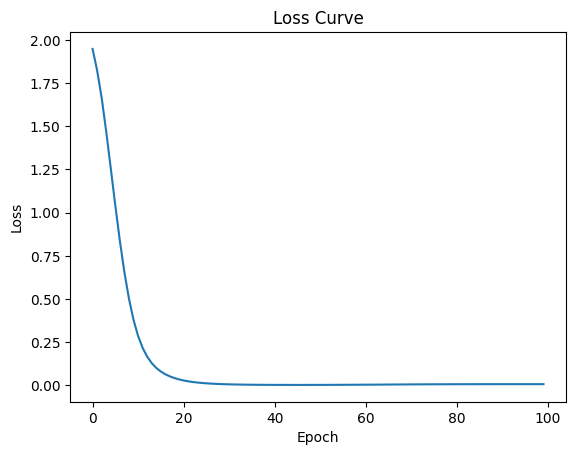

Accuracy: 0.5448

combine
Epoch: 10, Loss: 0.1903272122144699
Epoch: 20, Loss: 0.005439890548586845
Epoch: 30, Loss: 0.0007136922795325518
Epoch: 40, Loss: 0.00045104100718162954
Epoch: 50, Loss: 0.0006940423627384007
Epoch: 60, Loss: 0.0014198737917467952
Epoch: 70, Loss: 0.002488640835508704
Epoch: 80, Loss: 0.0033803172409534454
Epoch: 90, Loss: 0.0039020462427288294
Epoch: 100, Loss: 0.004093418829143047


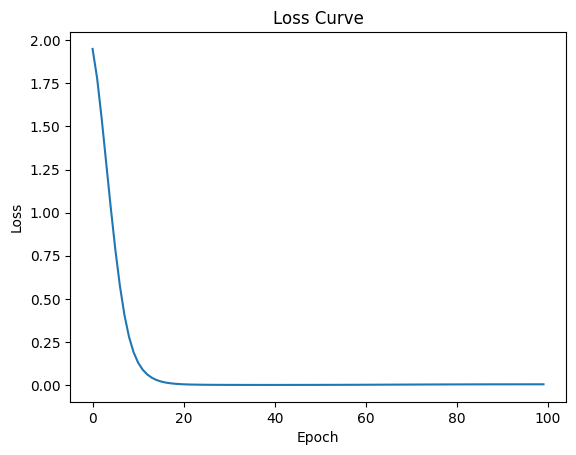

Accuracy: 0.7403


In [ ]:
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

X = torch.tensor(X, dtype=torch.float)
modes = ['structure_only', 'text_only', 'combine']
for mode in modes:
    print()
    print(mode)
    if mode == 'structure_only':
        tmpX = N2V
    if mode == 'text_only':
        tmpX = X
    if mode == 'combine':
        tmpX = torch.cat((N2V, X), dim=1)
    

    model = NN(input_dim=tmpX.shape[1], hidden_dim=32, output_dim=7)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_mask = torch.tensor(train_mask, dtype=torch.bool)
    test_mask = torch.tensor(test_mask, dtype=torch.bool)
    Y = torch.tensor(Y, dtype=torch.long)

    loss_history = []
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(tmpX)

        loss = criterion(output[train_mask], Y[train_mask])
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if (epoch+1) % 10 == 0:
            print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

    plt.plot(loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.show()

    model.eval()
    output = model(tmpX)
    _, pred = output.max(dim=1)

    correct = float(pred[test_mask].eq(Y[test_mask]).sum().item())
    accuracy = correct / test_mask.sum().item()
    print("Accuracy: {:.4f}".format(accuracy))

    # model.eval()
    # output = model(X, edge_index).detach().numpy()
    # tsne = TSNE(n_components=2, random_state=42)
    # output_2d = tsne.fit_transform(output)

    # plt.scatter(output_2d[:, 0], output_2d[:, 1], c=Y.numpy(), cmap='viridis', s=15)
    # plt.xlabel("t-SNE Dim 1")
    # plt.ylabel("t-SNE Dim 2")
    # plt.title("t-SNE Visualization")
    # plt.show()

# personalized PageRank

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score
from collections import defaultdict
import random

train_indexs = {}
test_indexs = []

for i, label in enumerate(labels):
    if label not in train_indexs:
        train_indexs[label] = [i]
    elif len(train_indexs[label]) < 20:
        train_indexs[label].append(i)
    else:
        test_indexs.append(i)


def random_walk(transition_probs, label, T=5, pout=0.2):
    rst = []
    for starter in train_indexs[label]:
        # walk T times
        # rst.append(starter)
        current_node = starter
        for i in range(T):
            if random.random() < pout:
                next_node = random.choices(train_indexs[label])[0]  # 20 seeds
            else:
                probs = transition_probs[current_node]
                next_node = random.choices(range(N), probs)[0]  # neighbors
            current_node = next_node
        rst.append(current_node)
    return rst

# part a: transition_probs = A 
A = np.array(nx.adjacency_matrix(G).todense())

# part b: transition_probs = cosine_similarity
transition_probs = cosine_similarity(X, X)
transition_probs = np.exp(transition_probs)
transition_probs = np.where(A==1, transition_probs, 0)


for i in range(N):
    if transition_probs[i].sum() == 0:
        transition_probs[i] = A[i]

for trans in [A, transition_probs]:
    for pout in [0, 0.1, 0.2]:
        pred_map = np.zeros((N, 7))
        for label in class_dict:
            rst = []
            for walk_times in range(1000):
                rst += random_walk(trans, label, T=20, pout=pout)
            count = Counter(rst)
            for test_i in test_indexs:
                pred_map[test_i][class_dict[label]] = count[test_i]

        pred_label_ori = np.argmax(pred_map, axis=1)
        pred_label = pred_label_ori[test_indexs]
        true_label = np.array(Y)[test_indexs]
        accuracy = accuracy_score(true_label, pred_label)
        f1 = f1_score(true_label, pred_label, average='weighted')

        # print(trans, pout)
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7251
F1 Score: 0.7263
Accuracy: 0.7391
F1 Score: 0.7407
Accuracy: 0.7259
F1 Score: 0.7273
Accuracy: 0.7231
F1 Score: 0.7244
Accuracy: 0.7352
F1 Score: 0.7373
Accuracy: 0.7317
F1 Score: 0.7333
